In [1]:
# Copyright © 2019-2021 Intel Corporation.
# 
# This software and the related documents are Intel copyrighted
# materials, and your use of them is governed by the express 
# license under which they were provided to you (License). Unless
# the License provides otherwise, you may not use, modify, copy, 
# publish, distribute, disclose or transmit  this software or the
# related documents without Intel's prior written permission.
# 
# This software and the related documents are provided as is, with
# no express or implied warranties, other than those that are 
# expressly stated in the License.

In [2]:
import os
from IPython.display import Image
import matplotlib.pyplot as plt
import nxsdk_modules.lca as lca 

# Solving convolutional LASSO with LCA

This tutorial demonstrates how to perform image de-noising through sparse coding by using the locally competitive algorithm (LCA) as a solver for the sparse coding problem.

In sparse coding, the goal is the to represent an input/signal/... $x$ through a linear combination of features $\Phi_i$ with coefficients $a_i$. All features typically form an overcomplete dictionary $\Phi$ while most coefficients $a_i$ are zero as illustrated for this image example:

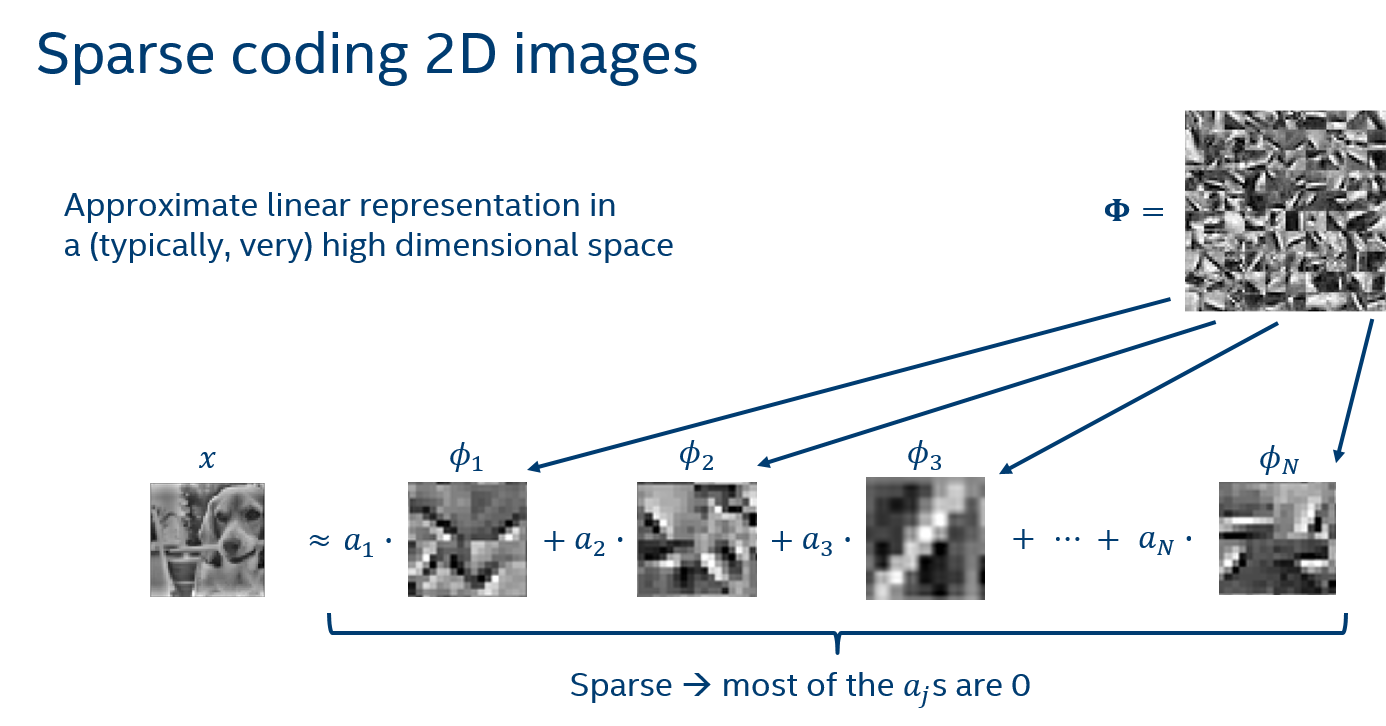

In [26]:
Image(filename = "figures/Solving convolutional Lasso with LCA_image_sparse_coding.png", width=600, height=500)

This objective is expressed by the LASSO cost function:

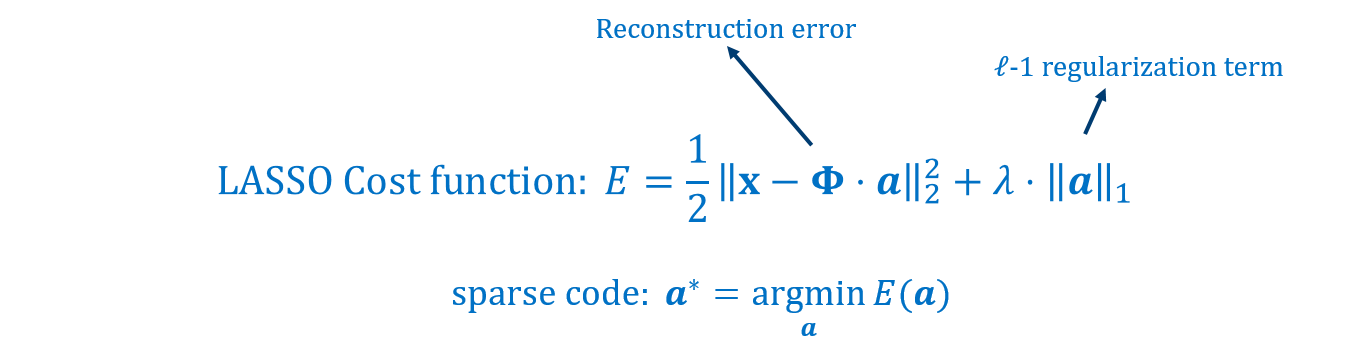

In [27]:
Image(filename = "figures/Solving convolutional Lasso with LCA_Cost_function.png", width=800, height=500)

Performing gradient descent on this objective, leads to the LCA dynamics which has a correspondance to a recurrent neural network. In this network, feature neurons $a_i$ with an associated feature vector $\Phi_i$ compete in proportion to $\Phi_i^T \cdot \Phi_j$ to represent the input $x$.

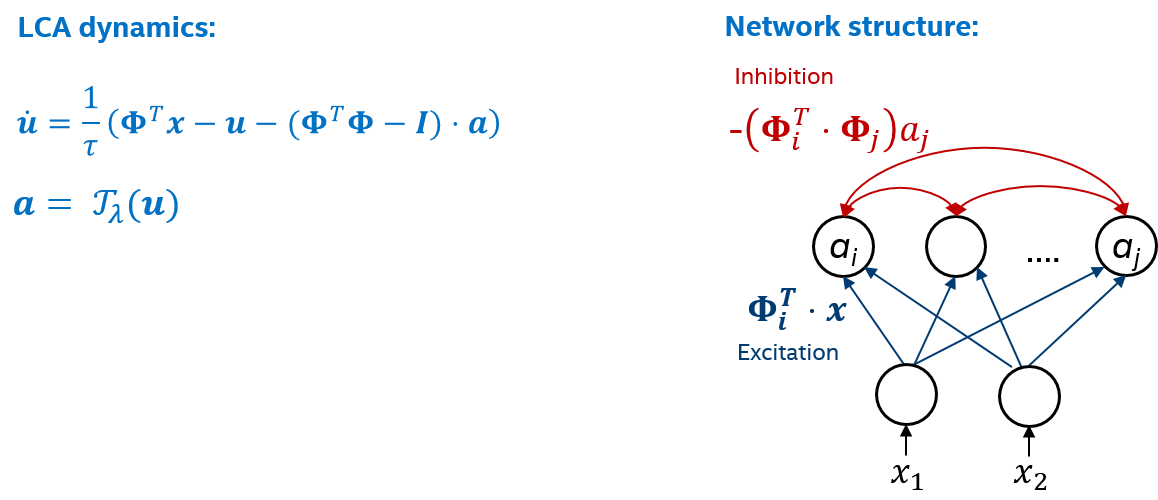

In [5]:
Image(filename = "figures/Solving convolutional Lasso with LCA_LCA_dynamics.png", width=1000, height=500)

On Loihi, 2D image sparse coding problems can be solved efficiently via convolutioanl LCA. In this case, LCA is applied to individual patches of the input space. In addition, feature neurons do not only compete within a patch but also accross patches depending on patch overlap:

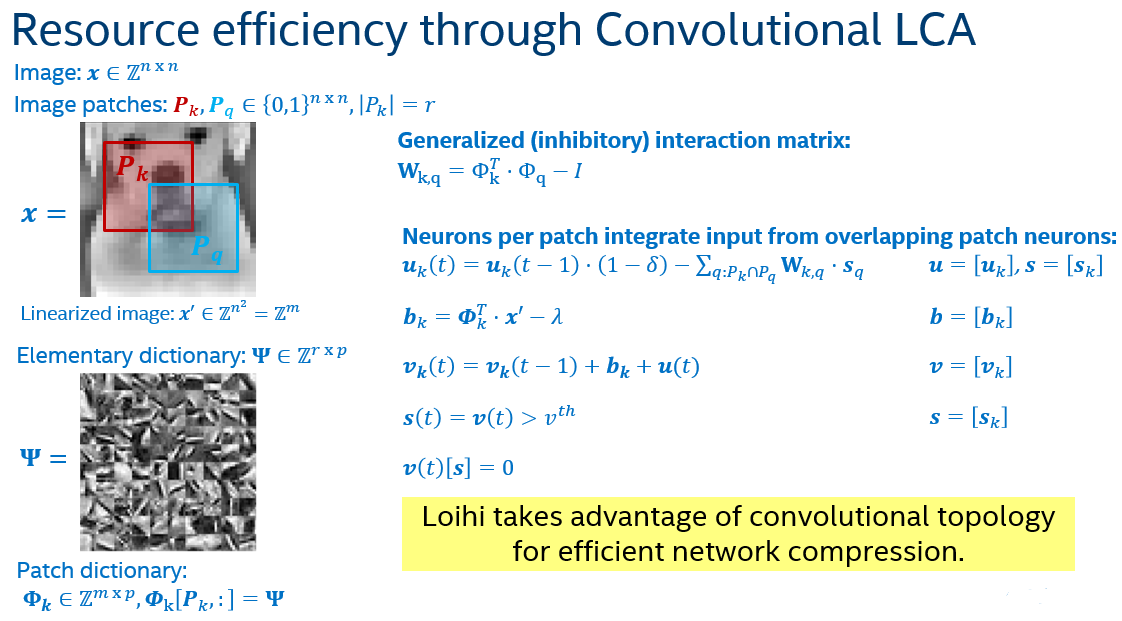

In [6]:
Image(filename = "figures/Solving convolutional Lasso with LCA_Convolutional_dynamics.png", width=1000, height=500)

The LcaNet module implements this convolutional LCA solver and is used in the following to perform an image denoising task:

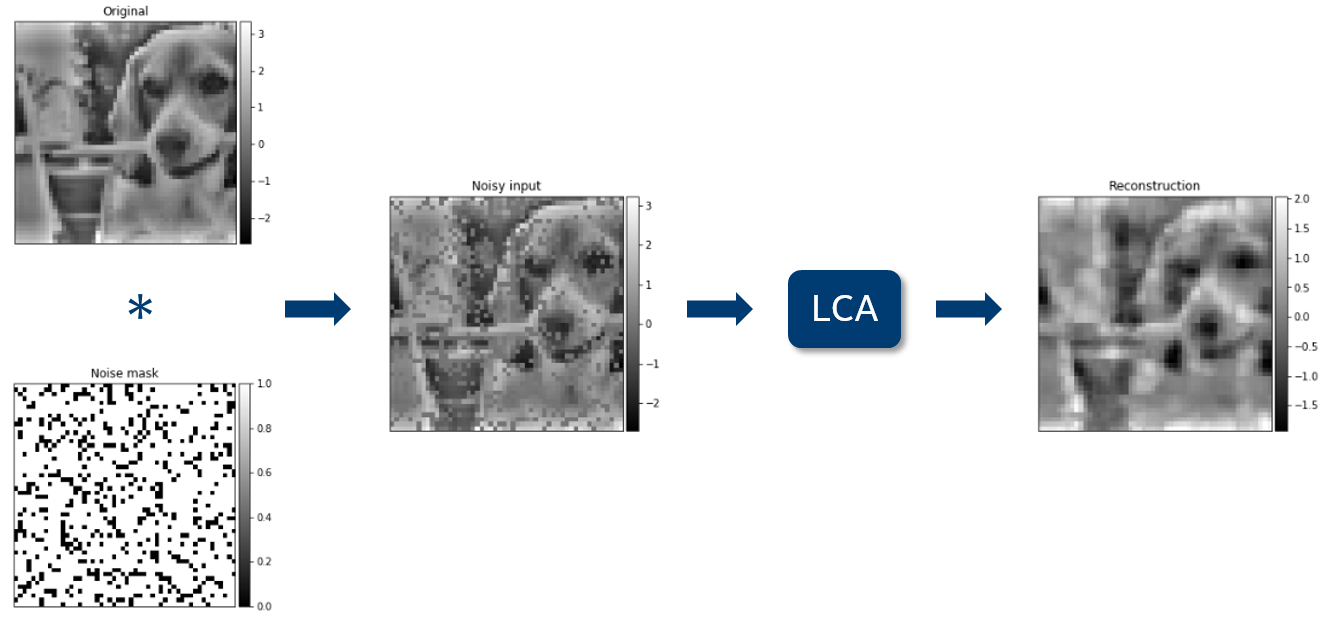

In [7]:
Image(filename = "figures/Solving convolutional Lasso with LCA_Denoising_overview.png", width=1000, height=500)

## Model and compile paramters

To set up the LCA solver, the LcaNet module requires a number of mandatory and optional configuration parameters related to the model itself and compilation of the model.

In [33]:
# First we, configure the model parameters of LCA network:
# imageSize must match the image's size to be provided later
# patchSize determines the size of a (convolutional) patch
# which strides across the image at the specified stride size
mp = lca.ModelParams()
mp.setImgParamsXY(imgSizeX=52,
                  patchSizeX=8,
                  strideSizeX=4,
                  imgSizeY=52,
                  patchSizeY=8,
                  strideSizeY=4)
# The dictSize must match the number of dictionary element (number of rows in the dictionary matrix)
mp.dictSize = 112
# The regularization factor determines the sparsity of the solution
mp.regularizationFactor = 1.2
# tauU is the decay time constant of the compartment compartmentCurrent in ms
mp.tauU = 0.64
# timePerStep is the time in ms per algorithmic time step
mp.timePerStep = 0.02
# wgtExp scales the magnitude of the accumulated inhibitory weights by 2**-wgtExp
mp.wgtExp = -4
# wgtPrecision is the precision of weights used here
mp.wgtPrecision = 4
# In this example, the network is calibrated such that wgtPrecision - wgtExp = 8

# Configures the activity probes (used for determination of spike rates) to 
# be evaluated after an initial probeOffset and then at an interval of probeInterval.
mp.probeInterval = 1
mp.probeOffset = 0

# Configures the network to run for numEpochs*numStepsPerEpoch time steps. numStepsPerEpoch should be a multiple of  probeInterval
mp.numEpochs = 1
mp.numStepsPerEpoch = 128

# Next we configure, the compile parameters of LCA network using default parameters:
cp = lca.CompileParams()

## Network generation
With these parameter classes we can generates the LcaNet and allocates resources: <br>
Given the imageSize, patchSize, stride and dictionary size, a number of neuronGroups are created for every image patch. An image patch is a 2D area of size (patchSizeY x patchSizeX) that strides across the image space. Each neuronGroup has 2*dictSize neurons because positive and negative portions of a dictionary element are represented by two different neurons.<br>
NeuronGroups are mutually connected by inhibitory weight matrices if the underlying patches overlap in input space. The weight matrix elements are essentially proportional to the location adjusted dot product of the underlying dictionary elements.

In [34]:
lcaNet = lca.LcaNet(mp, cp)
lcaNet.generateNetwork()

Generating network... Done (1.92s)


## Visualization of network properties
### Patch coverage of input image space
The patchCoverage is a 2D map showing how many patches cover an area in the input space.

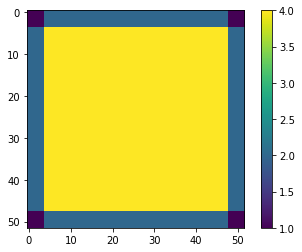

In [10]:
lcaNet.showPatchCoverage()

### Mutual patch overlap mask/signatures
An overlapMask is the union of the patch areas of a pair of patches. The following method plot the set of all unique overlapMasks of this network which are then used to determine the unique set of weight matrices connecting pairs of neuronGroups.  Note, only the yellow areas are the overlap masks.  The purple areas are simply filling in space so all masks can be printed as same size squares.

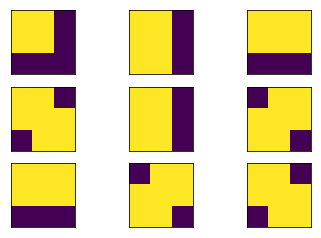

In [11]:
lcaNet.showOverlapMasks()

### Neuron group connectivity
The next method plot a connectivity matrix not between individual neurons but neuronGroups.

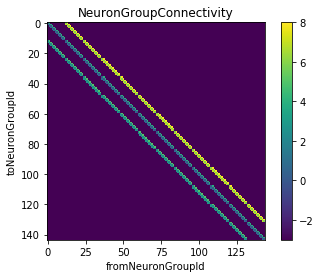

In [12]:
lcaNet.showGroupConnectivity()

## Resource requirements
The LcaNet class provides a ResourceRequirements class that is used to compute the required hardware resources per core as well as the total number of cores. Once the network is generated, we can use it to plot the resource utilization given the number of neurons per neuronGroup.

As the numNeuronsPerGroup increases, we require more and more compartment and synaptic resources. The resource requirements per NeuroCore increase in a nonlinear fashion because when ever a new NeuroCore is consumed new resources become available to the network.

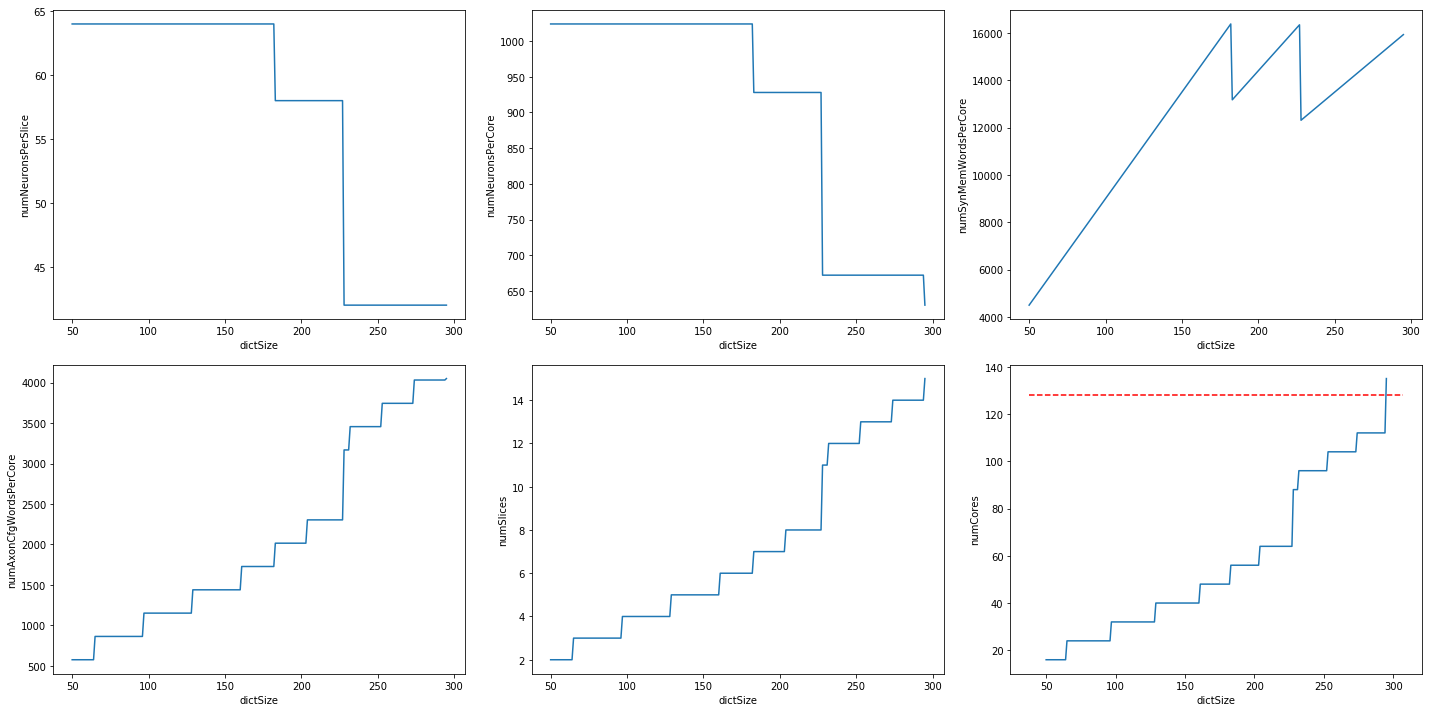

In [13]:
plt.figure(figsize=(20,10))
_ = lcaNet.resourceRequirements.sweepDictSize(dictSizes=range(50, 296),
                                          imgSize=48,
                                          patchSize=8,
                                          strideSize=4,
                                          showSweep=True)

## Set dictionary and input

### Load data

In [35]:
import numpy as np
dataDir = os.path.abspath('./a_data')
dictionary = lca.utils.loadCsv(dataDir, 'a_dictionary_112x64.csv')
img = lca.utils.loadCsv(dataDir, 'a_dog_52x52.csv')

### Corrupt input by noise

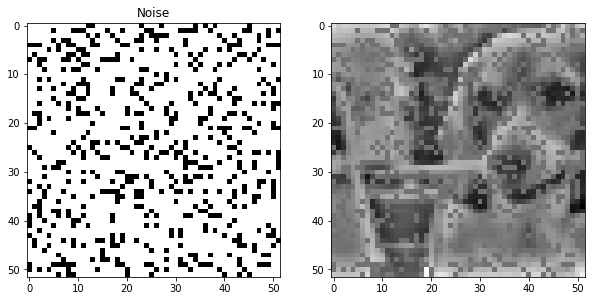

In [36]:
import numpy as np

ratioCorruptedPixels = 0.2
mask = (np.random.random(img.shape)>ratioCorruptedPixels).astype(int)
noisyImg = img*mask

plt.figure(1001, figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(mask.transpose(), aspect='equal', cmap='gray')
plt.title('Noise')

plt. subplot(1, 2, 2)
plt.imshow(noisyImg.transpose(), aspect='equal', cmap='gray')

plt.show()

### Configure LcaNet

In [37]:
# Setting the dictionary automatically updates all weight matrices in the network.
lcaNet.setDictionary(dictionary)
# Setting the input image automatically updates all bias currents in the network. Thus the dictionary has to be set before the input.
lcaNet.setInput(noisyImg)

Setting up dictionary and generating weights... Done (26.21s)
Setting up input image and generating bias currents... Done (0.31s)



### Visualization of dictionary and input image
The provided dictionary and input can also be visualized for diagnostic purposes:<br>
Every dictionary element (i.e. row of the dictionary matrix) is reshaped into a 2D (patchSizeY x patchSizeX) matrix before 
plotting.

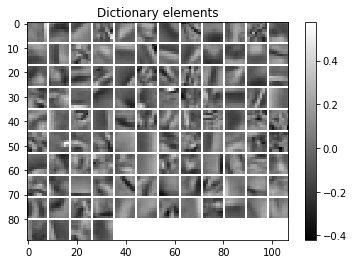

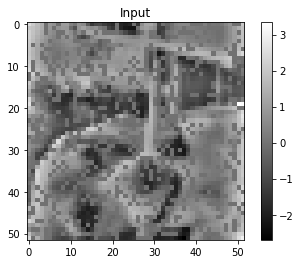

In [38]:
lcaNet.showDictionary(figId=0)
lcaNet.showInput(figId=1)

## Solving the sparse coding problem
With the entire network configured, we can run the LCA network to solve the sparse coding problem.

In [39]:
# LcaNet.solve() will run the network for numEpochs*numStepsPerEpoch time steps and compute the reconstruction error, the objective and sparsity of the solution.
sol = lcaNet.solve()
# Once the run has finished, a new dictionary or input can be set and solve() can be called again. If this is the end, it's good practice to disconnect from the hardware in order to not block resources.
lcaNet.board.disconnect()

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.93:33863
INFO:DRV:      Host server up..............Done 0.21s
INFO:DRV:      Encoding axons/synapses.....Done 3.96s
INFO:DRV:      Booting up..................Done 0.48s
INFO:DRV:      Encoding probes.............Done 0.04s
INFO:DRV:      Configuring registers.......Done 1.55s
INFO:DRV:      Transferring spikes.........Done 0.73ms
INFO:DRV:      Transferring probes.........Done 0.33s
INFO:DRV:      Executing...................Done 22.11s
INFO:DRV:      Processing timeseries.......Done 23.66s
INFO:DRV:  Executor: 128 timesteps.........Done 53.03s


## Show results
Finally we can plot the temporal evolution of the spike count error, objective and sparsity.

### Spike count and spike raster

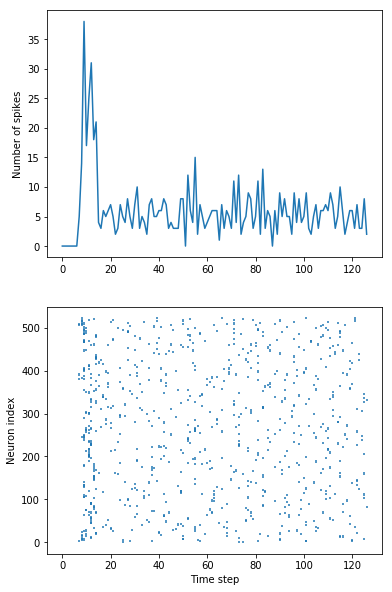

In [19]:
import nxsdk.utils.plotutils as pu

# Extract spike events from spike counts
activeNeuronIdx = np.any(sol.numSpikes > 0, axis=0)
numSpikesActive = sol.numSpikes[:, activeNeuronIdx]
activeNeuronSpikes = numSpikesActive[1:,:] - numSpikesActive[:-1,:]
numTotalSpikes = np.sum(activeNeuronSpikes, axis=1)

# Filter out spike times
spikeTimes = []
for i in range(activeNeuronSpikes.shape[1]):
    spikeTimes.append(np.where(activeNeuronSpikes[:, i])[0])

# Plot spikes (only of active neurons)
plt.figure(figsize=(6,10))
ax = plt.subplot(2, 1, 1)
plt.plot(numTotalSpikes)
plt.ylabel('Number of spikes')

plt.subplot(2, 1, 2)
ls = pu.plotRaster(spikeTimes, linewidths=20)
plt.gca().set_xlim(ax.get_xlim())
for l in ls:
    l.set_linelength(5)
plt.xlabel('Time step')
plt.ylabel('Neuron index')

plt.show()

### Convergence behavior

Below the reconstuction error, objective, and activty are plotted.  Note that activty is the percentage of compartments that have spiked.


Sparse coding solution at t=128:
Error     = 597.50
Objective = 662.50
Sparsity  = 1.62%


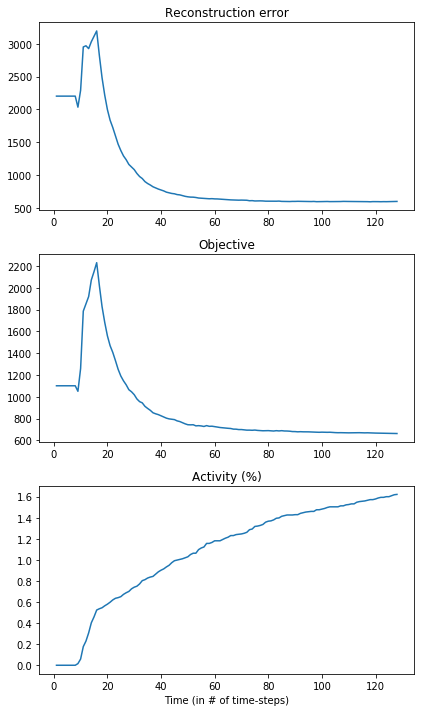

In [20]:
# Plot convergence behavior of error, objective and sparsity
plt.figure(figsize=(6,10))
sol.plotConvergence()
plt.tight_layout()
sol.print()

### Reconstruction

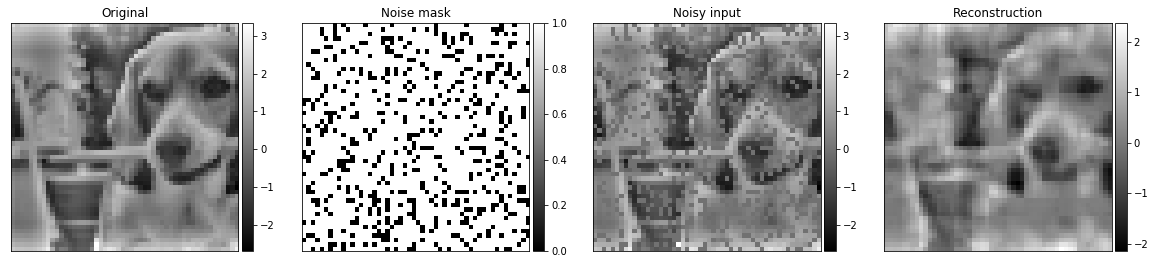

In [21]:
plt.figure(2001, figsize=(20, 10))
axa = plt.subplot(1, 4, 1)
axa.xaxis.set_visible(False)
axa.yaxis.set_visible(False)
imga = plt.imshow(img.transpose(), cmap='gray', aspect='equal')
plt.title('Original')
sol.makeColorbar(imga)
axb = plt.subplot(1, 4, 2)
axb.xaxis.set_visible(False)
axb.yaxis.set_visible(False)
imgb = plt.imshow(mask.transpose(), cmap='gray', aspect='equal')
plt.title('Noise mask')
sol.makeColorbar(imgb)
axc = plt.subplot(1, 4, 3)
axc.xaxis.set_visible(False)
axc.yaxis.set_visible(False)
imgc = plt.imshow(sol.input.transpose(), cmap='gray', aspect='equal')
plt.title('Noisy input')
sol.makeColorbar(imgc)
axd = plt.subplot(1, 4, 4)
axd.xaxis.set_visible(False)
axd.yaxis.set_visible(False)
imgd = plt.imshow(sol.finalReconstruction.transpose(), cmap='gray', aspect='equal')
plt.title('Reconstruction')
sol.makeColorbar(imgd)
plt.show()

### Evolution of reconstruction

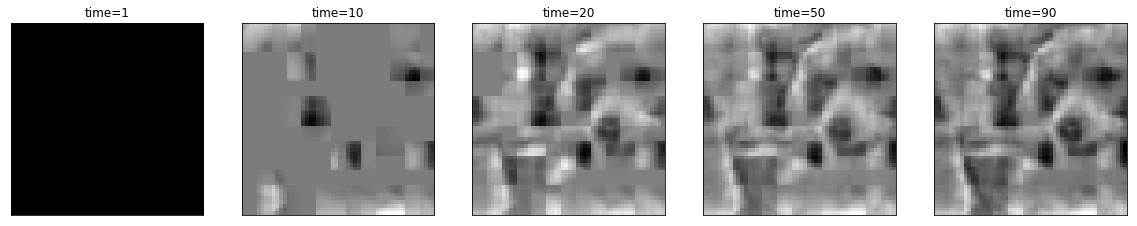

In [22]:
def plotImg(img, timeStep, ax):
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    imga = plt.imshow(np.reshape(img.transpose(), (52, 52)), cmap='gray', aspect='equal')
    plt.title('time={}'.format(timeStep))

plt.figure(100, figsize=(20,10))

ax = plt.subplot(1, 5, 1)
plotImg(sol.reconstruction[1,:,:], '1', ax)

ax = plt.subplot(1, 5, 2)
plotImg(sol.reconstruction[10,:,:], '10', ax)

ax = plt.subplot(1, 5, 3)
plotImg(sol.reconstruction[20,:,:], '20', ax)

ax = plt.subplot(1, 5, 4)
plotImg(sol.reconstruction[50,:,:], '50', ax)

ax = plt.subplot(1, 5, 5)
plotImg(sol.reconstruction[90,:,:], '90', ax)

plt.show()

### Animation of reconstruction process
#### _Pre-requisite is ffmpeg installed on the system_

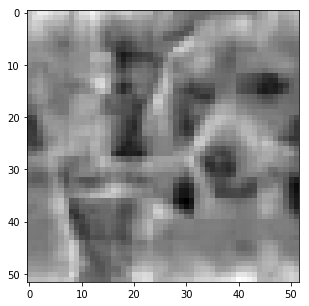

In [23]:
import matplotlib.animation as animate
from IPython.display import HTML
    
# Check for ffmpeg with BaSH
isFfmpegInstalled = !if hash ffmpeg 2> /dev/null; then echo 1; else echo 0; fi
isFfmpegInstalled = int(isFfmpegInstalled[0])

if isFfmpegInstalled:
    fig22 = plt.figure(100, figsize=(5, 5))
    axa.xaxis.set_visible(False)
    axa.yaxis.set_visible(False)

    ims = []
    for j in range(sol.reconstruction.shape[0]):
        im = plt.imshow(np.transpose(np.reshape(sol.reconstruction[j, :, :], (52, 52))), cmap='gray', aspect='equal', animated=True)
        ims.append([im])
    
    ani = animate.ArtistAnimation(fig22, ims, interval=50, blit=True)
    out = ani.to_html5_video()
    
else: # ffmpeg is not installed. Warn as such.
    out = '<font size="+1">ffmpeg is required to create this animation.<br> Please install using <code> apt install ffmpeg </code>.</font>'

HTML(out)